In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

# basic libraries
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
from pathlib import Path
from typing import List

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import torchsummaryX
from torch import Tensor

plt.ion()   # interactive mode

print(torch.__version__)

1.8.1+cu102


## Initialize Variables

In [23]:
MODEL_NAME = 'resnet18'
OPTIMIZER = 'ADAM' #'SGD', 'ADAM'
PRETRAIN = False
EPOCH_NUM = 300 # 300
BATCH_SIZE = 64
SCALE_FACTOR = 1

if(MODEL_NAME == 'resnet18'):
    RESCALE_SIZE = 256
    CROP_SIZE = 224

DATASET = 'default_train_test/'
DATA_DIR = 'data/' + DATASET
CHECKPOINTS_DIR = './checkpoints/' + DATASET

MODEL_PREFIX = CHECKPOINTS_DIR + MODEL_NAME

BEST_MODEL_PATH = MODEL_PREFIX + '_model_best.pth'
LAST_MODEL_PATH = MODEL_PREFIX + '_model_last.pth'
LOSS_PATH       = MODEL_PREFIX + '_loss.txt'
ACCURACY_PATH   = MODEL_PREFIX + '_accuracy.txt'
    
Path('data').mkdir(parents=True, exist_ok=True)
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path('checkpoints').mkdir(parents=True, exist_ok=True)
Path(CHECKPOINTS_DIR).mkdir(parents=True, exist_ok=True)

print(BEST_MODEL_PATH)
print(LAST_MODEL_PATH)

./checkpoints/default_train_test/resnet18_model_best.pth
./checkpoints/default_train_test/resnet18_model_last.pth


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(CROP_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(CROP_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = DATA_DIR
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
class_num = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print(class_num)
print(device)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

## Visualize Some Images


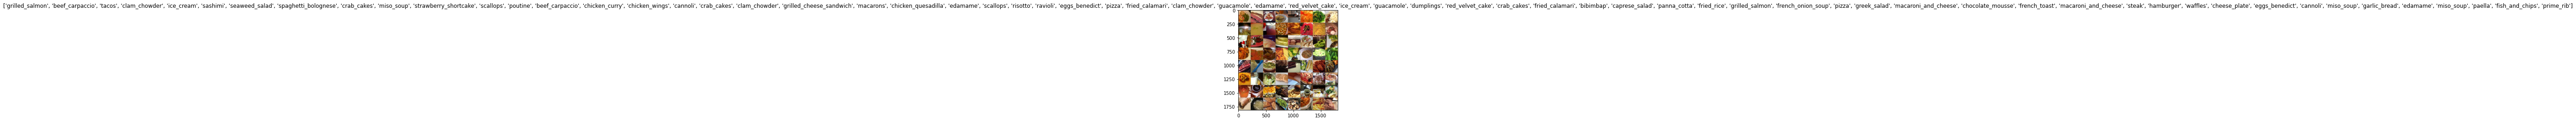

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Training Codes

In [6]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    since = time.time()

    #best_epoch = 0
    #best_acc = 0.0
    #best_model_wts = copy.deepcopy(model.state_dict())
    
    loss_values = {'train': [], 'val': []}
    acc_values = {'train': [], 'val': []}
    lr_values = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        #for phase in ['train', 'val']:
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu().detach().numpy()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            loss_values[phase].append(epoch_loss)
            acc_values[phase].append(epoch_acc)
            if phase == 'train':
                lr_values[phase].append(get_lr(optimizer))

            # deep copy the model
            #if phase == 'val' and epoch_acc > best_acc:
                #best_epoch = epoch
                #best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())

        print()

    last_model_wts = copy.deepcopy(model.state_dict())
    last_acc = epoch_acc
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f} at {}'.format(best_acc, best_epoch))
    #print('Last val Acc: {:4f}'.format(last_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    loss_values['val'] = 0
    acc_values['val'] = 0
    lr_values['val'] = 0
    
    #return best_model_wts, last_model_wts, loss_values, acc_values, lr_values
    return last_model_wts, loss_values, acc_values, lr_values

## Choose Models

In [8]:
model = models.resnet18(pretrained=PRETRAIN)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, class_num)

model = model.to(device)
criterion = nn.CrossEntropyLoss()

if(OPTIMIZER == 'SGD'):
    # Observe that all parameters are being optimized
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
elif(OPTIMIZER == 'ADAM'):
    # not yet optimized
    optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam
    exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, 0.99) #Adam
    #exp_lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1)) #Adam

## Model Summary

In [9]:
input = torch.rand((1, 3, CROP_SIZE, CROP_SIZE)).to(device)
torchsummaryX.summary(model, input)

                                          Kernel Shape       Output Shape  \
Layer                                                                       
0_conv1                                  [3, 64, 7, 7]  [1, 64, 112, 112]   
1_bn1                                             [64]  [1, 64, 112, 112]   
2_relu                                               -  [1, 64, 112, 112]   
3_maxpool                                            -    [1, 64, 56, 56]   
4_layer1.0.Conv2d_conv1                 [64, 64, 3, 3]    [1, 64, 56, 56]   
5_layer1.0.BatchNorm2d_bn1                        [64]    [1, 64, 56, 56]   
6_layer1.0.ReLU_relu                                 -    [1, 64, 56, 56]   
7_layer1.0.Conv2d_conv2                 [64, 64, 3, 3]    [1, 64, 56, 56]   
8_layer1.0.BatchNorm2d_bn2                        [64]    [1, 64, 56, 56]   
9_layer1.0.ReLU_relu                                 -    [1, 64, 56, 56]   
10_layer1.1.Conv2d_conv1                [64, 64, 3, 3]    [1, 64, 56, 56]   

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv1,"[3, 64, 7, 7]","[1, 64, 112, 112]",9408.0,118013952.0
1_bn1,[64],"[1, 64, 112, 112]",128.0,64.0
2_relu,-,"[1, 64, 112, 112]",NaN,NaN
3_maxpool,-,"[1, 64, 56, 56]",NaN,NaN
4_layer1.0.Conv2d_conv1,"[64, 64, 3, 3]","[1, 64, 56, 56]",36864.0,115605504.0
5_layer1.0.BatchNorm2d_bn1,[64],"[1, 64, 56, 56]",128.0,64.0
6_layer1.0.ReLU_relu,-,"[1, 64, 56, 56]",NaN,NaN
7_layer1.0.Conv2d_conv2,"[64, 64, 3, 3]","[1, 64, 56, 56]",36864.0,115605504.0
8_layer1.0.BatchNorm2d_bn2,[64],"[1, 64, 56, 56]",128.0,64.0


## Train Model

In [10]:
last_model_wts, loss_values, acc_values, lr_values = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCH_NUM)
#best_model_wts, last_model_wts, loss_values, acc_values, lr_values = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCH_NUM)

Epoch 0/299
----------
train Loss: 4.2044 Acc: 0.0690

Epoch 1/299
----------
train Loss: 3.7418 Acc: 0.1391

Epoch 2/299
----------
train Loss: 3.3416 Acc: 0.2128

Epoch 3/299
----------
train Loss: 3.0064 Acc: 0.2781

Epoch 4/299
----------
train Loss: 2.7309 Acc: 0.3359

Epoch 5/299
----------
train Loss: 2.5205 Acc: 0.3823

Epoch 6/299
----------
train Loss: 2.3510 Acc: 0.4220

Epoch 7/299
----------
train Loss: 2.2074 Acc: 0.4512

Epoch 8/299
----------
train Loss: 2.0870 Acc: 0.4809

Epoch 9/299
----------
train Loss: 1.9786 Acc: 0.5041

Epoch 10/299
----------
train Loss: 1.8960 Acc: 0.5221

Epoch 11/299
----------
train Loss: 1.8063 Acc: 0.5409

Epoch 12/299
----------
train Loss: 1.7358 Acc: 0.5581

Epoch 13/299
----------
train Loss: 1.6746 Acc: 0.5712

Epoch 14/299
----------
train Loss: 1.6109 Acc: 0.5883

Epoch 15/299
----------
train Loss: 1.5613 Acc: 0.5984

Epoch 16/299
----------
train Loss: 1.5034 Acc: 0.6120

Epoch 17/299
----------
train Loss: 1.4487 Acc: 0.6247

Ep

train Loss: 0.2940 Acc: 0.9227

Epoch 147/299
----------
train Loss: 0.2898 Acc: 0.9235

Epoch 148/299
----------
train Loss: 0.2899 Acc: 0.9235

Epoch 149/299
----------
train Loss: 0.2985 Acc: 0.9197

Epoch 150/299
----------
train Loss: 0.2890 Acc: 0.9237

Epoch 151/299
----------
train Loss: 0.2901 Acc: 0.9232

Epoch 152/299
----------
train Loss: 0.2879 Acc: 0.9237

Epoch 153/299
----------
train Loss: 0.2922 Acc: 0.9235

Epoch 154/299
----------
train Loss: 0.2905 Acc: 0.9238

Epoch 155/299
----------
train Loss: 0.2788 Acc: 0.9263

Epoch 156/299
----------
train Loss: 0.2845 Acc: 0.9245

Epoch 157/299
----------
train Loss: 0.2826 Acc: 0.9247

Epoch 158/299
----------
train Loss: 0.2808 Acc: 0.9253

Epoch 159/299
----------
train Loss: 0.2782 Acc: 0.9259

Epoch 160/299
----------
train Loss: 0.2773 Acc: 0.9258

Epoch 161/299
----------
train Loss: 0.2776 Acc: 0.9260

Epoch 162/299
----------
train Loss: 0.2741 Acc: 0.9275

Epoch 163/299
----------
train Loss: 0.2774 Acc: 0.9272


train Loss: 0.2016 Acc: 0.9463

Epoch 291/299
----------
train Loss: 0.1967 Acc: 0.9470

Epoch 292/299
----------
train Loss: 0.1989 Acc: 0.9478

Epoch 293/299
----------
train Loss: 0.1986 Acc: 0.9471

Epoch 294/299
----------
train Loss: 0.1952 Acc: 0.9483

Epoch 295/299
----------
train Loss: 0.1979 Acc: 0.9471

Epoch 296/299
----------
train Loss: 0.1990 Acc: 0.9470

Epoch 297/299
----------
train Loss: 0.1943 Acc: 0.9480

Epoch 298/299
----------
train Loss: 0.1912 Acc: 0.9492

Epoch 299/299
----------
train Loss: 0.1979 Acc: 0.9482

Training complete in 703m 1s


## Loss Curves

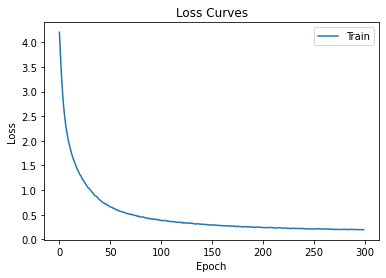

In [11]:
# store the loss values
with open(LOSS_PATH, "wb") as fp:   #Pickling
    pickle.dump(loss_values, fp)
    
# plot
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_values['train'], label = "Train")
#plt.plot(loss_values['val'], label = "val")
plt.legend()
plt.show()

## Accuracy Curves

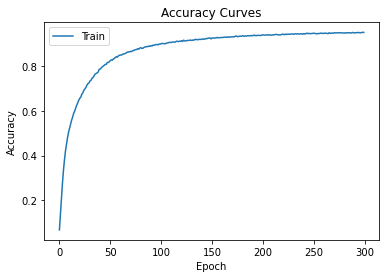

In [12]:
# store the accuracy values
with open(ACCURACY_PATH, "wb") as fp:   #Pickling
    pickle.dump(acc_values, fp)

# plot
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(acc_values['train'], label = "Train")
#plt.plot(acc_values['val'], label = "val")
plt.legend()
plt.show()

## Save The Best & The Last Models

In [13]:
# load best model weights & # load best model weights to models and save
#best_model = models.resnet18(pretrained=PRETRAIN)
#num_ftrs = best_model.fc.in_features
#best_model.fc = nn.Linear(num_ftrs, class_num)
#best_model.load_state_dict(best_model_wts)
#torch.save(best_model, BEST_MODEL_PATH)
    
last_model = models.resnet18(pretrained=PRETRAIN)
num_ftrs = last_model.fc.in_features
last_model.fc = nn.Linear(num_ftrs, class_num)
last_model.load_state_dict(last_model_wts)
torch.save(last_model, LAST_MODEL_PATH)

In [14]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in best_model.state_dict():
    #print(param_tensor, "\t", best_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
    #print(var_name, "\t", optimizer.state_dict()[var_name])

## Load Model to Have a Trial (Optional)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load(LAST_MODEL_PATH)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

[GT]   class index: 87, class name: scallops
[Pred] class index: 87, class name: scallops


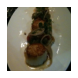

[GT]   class index: 58, class name: ice_cream
[Pred] class index: 58, class name: ice_cream


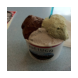

[GT]   class index: 61, class name: lobster_roll_sandwich
[Pred] class index: 61, class name: lobster_roll_sandwich


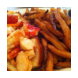

[GT]   class index: 35, class name: escargots
[Pred] class index: 35, class name: escargots


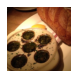

[GT]   class index: 51, class name: guacamole
[Pred] class index: 51, class name: guacamole


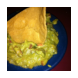

[GT]   class index: 59, class name: lasagna
[Pred] class index: 59, class name: lasagna


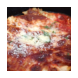

In [16]:
def visualize_model(model, folder, num_images=6):
    
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[folder]):
            
            #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                print("==========================================================================")
                print("[GT]   class index: {}, class name: {}".format(labels[j], class_names[labels[j]]))
                print("[Pred] class index: {}, class name: {}".format(preds[j], class_names[preds[j]]))
                    
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('ground-truth: {}, predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(model, 'test')

## Test

In [17]:
def estimateConfusionMatrix(model, nb_classes, folder, num_images=6):
    
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders[folder]):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    # 0: 'apple_pie', 1: 'baby_back_ribs', 2: 'baklava', 3: ... and so on
    #    pred 0 1 2 3 4
    # gt
    # 0
    # 1
    # 2
    # 3
    # 4
    confusion_matrix = confusion_matrix.numpy()
    
    return confusion_matrix

confusion_matrix_test = estimateConfusionMatrix(model, class_num, 'test')

print(confusion_matrix_test)

[[125.   0.   8. ...   3.   1.   7.]
 [  0. 187.   0. ...   0.   1.   1.]
 [  8.   0. 208. ...   1.   0.   0.]
 ...
 [  3.   0.   0. ... 191.   0.   0.]
 [  0.   0.   0. ...   0. 172.   0.]
 [  2.   1.   0. ...   0.   0. 201.]]


In [18]:
def estimateOtherMetrics(confusion_matrix):
    
    # Accuracy
    accuracy = confusion_matrix.diagonal().sum()/confusion_matrix.sum()*100
    
    # Recall
    recall = confusion_matrix.diagonal()/confusion_matrix.sum(1)
    
    # Precision
    precision = confusion_matrix.diagonal()/confusion_matrix.sum(0)
    
    # F1 Score
    f1_score = 2 * precision * recall / (precision + recall)
    
    # Number of failure cases
    failure_num = int(confusion_matrix.sum() - confusion_matrix.diagonal().sum())
    
    return accuracy, recall*100, precision*100, f1_score, failure_num

accuracy_test, recall_test, precision_test, f1_score_test, failure_num_test = estimateOtherMetrics(confusion_matrix_test)

print('== Test Set ==')
print('Accuracy: {}'.format(accuracy_test))
print('Recall: {}'.format(recall_test))
print('Precision: {}'.format(precision_test))
print('F1 Score: {}'.format(f1_score_test))
print('Number of misclassification: {}'.format(failure_num_test))

== Test Set ==
Accuracy: 75.57227611541748
Recall: [50.       74.8      83.200005 85.6      75.6      67.6      86.
 91.2      51.2      53.2      62.4      84.799995 76.4      81.6
 77.600006 66.       74.8      62.4      68.4      73.6      82.4
 58.8      55.6      80.8      82.4      86.       64.8      86.4
 85.2      85.2      89.200005 76.       87.6      97.2      86.4
 85.2      72.399994 58.399998 79.6      52.399998 77.200005 84.
 70.4      79.2      75.6      88.4      70.8      62.4      78.799995
 62.800003 64.4      87.6      79.6      72.399994 92.4      71.6
 58.399998 68.8      59.2      63.6      82.4      89.200005 74.4
 89.200005 89.200005 86.       67.6      66.399994 84.4      90.
 88.4      78.       82.4      60.8      82.4      91.2      82.
 39.6      86.4      82.4      71.6      76.8      47.2      88.
 61.6      73.6      83.200005 69.6      88.       74.       89.200005
 93.2      73.2      46.       76.4      82.8      69.6      84.799995
 76.4      68.8

## Visualize Some Failure Cases

In [19]:
def imshow_save(inp, file_name=None, title=None):
    """Imshow for Tensor."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if file_name is not None:
        plt.imsave(file_name, inp)

In [20]:
def visualize_model_failure(model, folder, is_save = False, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    softmax = torch.nn.Softmax(dim=-1)
    
    if(is_save):
        Path(FAILURE_DIR).mkdir(parents=True, exist_ok=True)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[folder]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            #print(outputs)
            outputs = softmax(outputs)
            #print(outputs)
            _, preds = torch.max(outputs, 1)
            
            outputs = outputs.to('cpu').numpy()
            outputs = np.around(outputs, 4) * 100
            #print(outputs)

            for j in range(inputs.size()[0]):
                if(labels[j] != preds[j]):
                    #if(class_names[labels[j]] == "defocus"):
                    images_so_far += 1

                    if(is_save):
                        file_name = FAILURE_DIR + str(images_so_far) + '_gt_' + class_names[labels[j]] + '_pred_'+ class_names[preds[j]] + '_b' + str(outputs[j][0]) + '_h' + str(outputs[j][1]) + '_n' + str(outputs[j][2]) + '.png'
                        print(file_name)
                    else:
                        file_name = None

                    print("==========================================================================")
                    print("[GT]   class index: {}, class name: {}".format(labels[j], class_names[labels[j]]))
                    print("[Pred] class index: {}, class name: {}".format(preds[j], class_names[preds[j]]))
                    imshow_save(inputs.cpu().data[j], file_name)

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
                    
        model.train(mode=was_training)

In [21]:
# 0: defocus, 1: haze, 2: normal, 3: soiling, 4: spray
np.set_printoptions(suppress=True)
#visualize_model_failure(model, 'val', False, 6)
#visualize_model_failure(model, 'test', True, failure_num)
np.set_printoptions(suppress=False)

In [22]:
#plt.ioff()
#plt.show()